# 4-body problem

<ul id="top">
    <li><a href="#Loading-packages-and-functions">Loading packages and functions</a></li>
    <li><a href="#Definition-of-the-N-body-problem">Definition of the N-body problem</a></li>
    <li><a href="#Integration">Integration</a></li>       
</ul>

## Loading packages and functions

In [1]:
using LinearAlgebra, Plots
using NbodyIRKGL16

In [2]:
#to install NbodyIRKGL16.jl package
#   using Pkg
#   Pkg.add(url="https://github.com/mikelehu/NbodyIRKGL16.jl") 


#Local version
#      PATH_SRC="../src/"
#      include(string(PATH_SRC,"NbodyIRKGL16.jl"))
#      using .NbodyIRKGL16 

##### <a href="#top">Back to the top</a>

## Definition of the N-body problem

### Initial value problem: 4-body 


A planar four-body problem where a strong close encounter between body2 and body3 

In [3]:
setprecision(BigFloat, 108)
fltype=Float64

PATH_ODES="../ODEProblems/"
include(string(PATH_ODES,"Initial4Body.jl"))
include(string(PATH_ODES,"Nbody.jl"))

u0, Gm, bodylist = Initial4Body(fltype)
N=length(Gm)
show(bodylist)


["body1" "body2" "body3" "body4"]

In [4]:
t0=fltype(0.)
tF=fltype(4.)  
tspan= (t0,tF)
prob = ODEProblem(NbodyODE_fstep!, u0,tspan , Gm);

##### <a href="#top">Back to the top</a>

## Integration

In [5]:
Dtau=fltype(0.6)
sol=solve(prob, nbirkgl16_simd(), adaptive=true, dt = Dtau)
sol.retcode

ReturnCode.Success = 1

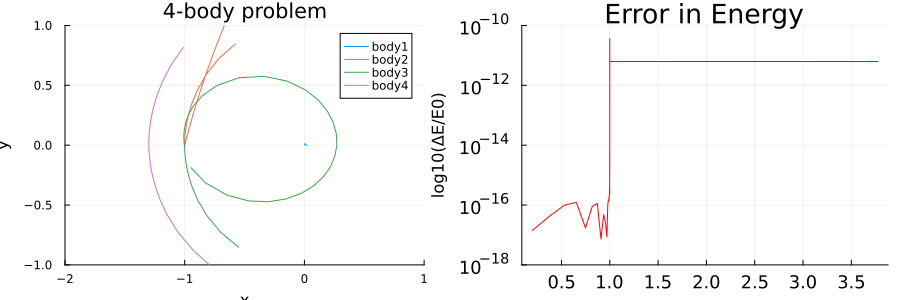

In [6]:
pl1 = plot(title="4-body problem", 
            xlabel="x", ylabel="y", 
            aspect_ratio=1,
            xlimit=(-2.,1.),
            ylimit=(-1,1)
)

for j = 1:N
    x  = [u[1,j,1] for u in sol.u]
    y  = [u[2,j,1] for u in sol.u] 
    pl1 = plot!(x,y, label=bodylist[j]) 
end 


yrange=(1e-18,1e-10)

E0=NbodyEnergy(BigFloat.(u0), BigFloat.(Gm))
ΔE = map(x->NbodyEnergy(BigFloat.(x),BigFloat.(Gm)), sol.u)./E0.-1;


pl2=plot(title="Error in Energy", xlabel="t", ylabel="log10(ΔE/E0)",
        titlefontsize=18,
        xtickfont = font(12),
        ytickfont = font(12),
        yscale=:log10,
        legend=:topright, ylims=yrange)

plot!(pl2,sol.t[2:end-1],abs.(ΔE[2:end-1]), color=:red, label="")


plot(pl1,pl2,layout=(1,2), size=(900,300))

### Close encounters between bodies

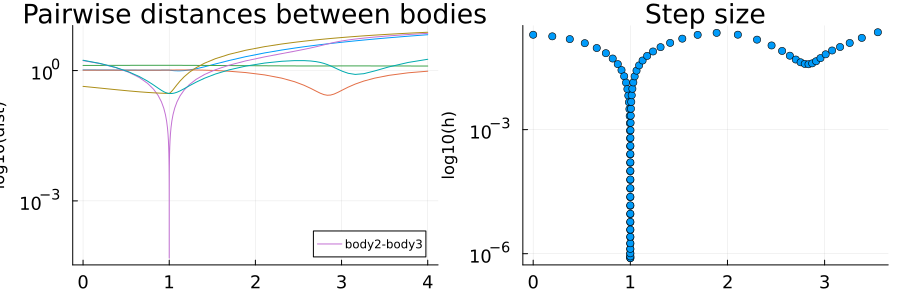

In [7]:
n=length(sol.t)
dist=Array{Vector{Float64}}(undef,N,N)
for i in 1:N
    for j in 1:N
        dist[i,j]=zeros(n)
    end
end

for i in 1:N
    A=[u[:,i,1]  for u in sol.u]
    for j in i+1:N
        B=[u[:,j,1]  for u in sol.u]
        dist[i,j]=map(x->norm(x), A-B)
    end
end

pl1 = plot(title="Pairwise distances between bodies", 
           titlefontsize=18,
           xtickfont = font(12),
           ytickfont = font(12),
           yscale=:log10,
           legend=:bottomright,
           xlabel="t", ylabel="log10(dist)")

for i in 1:N
    for j in i+1:N
        if (i==2 && j==3)
            plot!(pl1, sol.t,dist[i,j], label="body2-body3")
        else
            plot!(pl1, sol.t,dist[i,j], label="")
        end
    end
end


pl2= scatter(title="Step size",
             titlefontsize=18,
             xtickfont = font(12),
             ytickfont = font(12),
             yscale=:log10,
             xlabel="t", ylabel="log10(h)",
             label="",
             sol.t[1:end-2],
             abs.(sol.t[2:end-1].-sol.t[1:end-2]))


plot(pl1,pl2, layout=(1,2), size=(900,300))